In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
%matplotlib inline

In [2]:
class Body:
    def __init__(self, name, mass, position, velocity):
        self.name = name
        self.mass = mass.cgs.value
        self.position = position.cgs.value
        self.velocity = velocity.cgs.value
    
    # Объединенный вектор позиции и скорости тела - Y
    def getY(self):
        return np.concatenate((self.position, self.velocity))
    

In [3]:
class Simulation():
    def __init__(self, bodies):  
        self.bodies = bodies
        self.bodies_y = np.concatenate(np.array([body.getY() for body in self.bodies]))
        self.bodies_mass = np.array([body.mass for body in self.bodies])
    
    def set_differential_equation(self, differential_equation):
        self.differential_equation = differential_equation
    
    def method_RK4(self, dt):
        k1 = dt * self.differential_equation(self.bodies_y, self.bodies_mass) 
        k2 = dt * self.differential_equation(self.bodies_y + 0.5 * k1, self.bodies_mass)
        k3 = dt * self.differential_equation(self.bodies_y + 0.5 * k2, self.bodies_mass)
        k4 = dt * self.differential_equation(self.bodies_y + k3, self.bodies_mass)
        return self.bodies_y + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
    
    def run(self, T, dt):
        self.history = [self.bodies_y]
        
        t = (0 * T.unit).cgs.value
        dt = dt.cgs.value
        T = T.cgs.value
        steps = int(T / dt)
        start_time = time.time()
        
        for step in range(steps):
            self.bodies_y = self.method_RK4(dt)
            self.history.append(self.bodies_y)
            t += dt
            
            sys.stdout.flush()
            sys.stdout.write("Simulation: Step #{} of {} (simulation time = {})".format(step + 1, steps, round(t, 3)) + "\r")
        
        self.history = np.array(self.history)
        
        sys.stdout.flush()
        print("Simulation completed in {} seconds".format(round(time.time() - start_time, 3)))
    

In [4]:
def derivative_y(bodies_y, bodies_mass):
    bodies_len = int(len(bodies_y) / 6)
    answer = np.zeros(bodies_y.size)
    
    for i in range(bodies_len):
        answer[i * 6:i * 6 + 3] = bodies_y[i * 6 + 3:i * 6 + 6] # dr = dv
        
        for j in range(bodies_len): 
            if i != j:
                dx = bodies_y[i * 6 + 0] - bodies_y[j * 6 + 0] # rx
                dy = bodies_y[i * 6 + 1] - bodies_y[j * 6 + 1] # ry
                dz = bodies_y[i * 6 + 2] - bodies_y[j * 6 + 2] # rz
                r = (dx ** 2 + dy ** 2 + dz ** 2) ** 0.5 # r
                ax = ((-c.G.cgs * bodies_mass[j] / r**3) * dx).value # ax
                ay = ((-c.G.cgs * bodies_mass[j] / r**3) * dy).value # ay
                az = ((-c.G.cgs * bodies_mass[j] / r**3) * dz).value # az
                answer[i * 6 + 3] += ax # dvx += ax (of j body)
                answer[i * 6 + 4] += ay # dvy += ay (of j body)
                answer[i * 6 + 5] += az # dvz += az (of j body)
                
    return answer 

In [5]:
def createVector(x = 0, y = 0, z = 0):
    return np.array([x, y, z], float)

In [6]:
Moon = Body("Moon",
            mass = 7.3477e22 * u.kg,
            position = createVector(3.84e5, 0, 0) * u.km,
            velocity = createVector(0, 1.022, 0) * u.km / u.s)

Earth = Body("Earth",
             mass = c.M_earth,
             position = createVector(0, 0, 0) * u.km,
             velocity = createVector(0, 0, 0) * u.km / u.s)

Asteroid1 = Body("Asteroid1",
             mass = 1.09e5 * u.kg,
             position = createVector(1.84e5, 0, 0) * u.km,
             velocity = createVector(0, 1.822, 0) * u.km / u.s)

simulation = Simulation([Earth, Moon, Asteroid1])
simulation.set_differential_equation(derivative_y)
simulation.run(50 * u.day, 1 * u.hr)

Simulation completed in 11.984 secondstion time = 4320000.0)


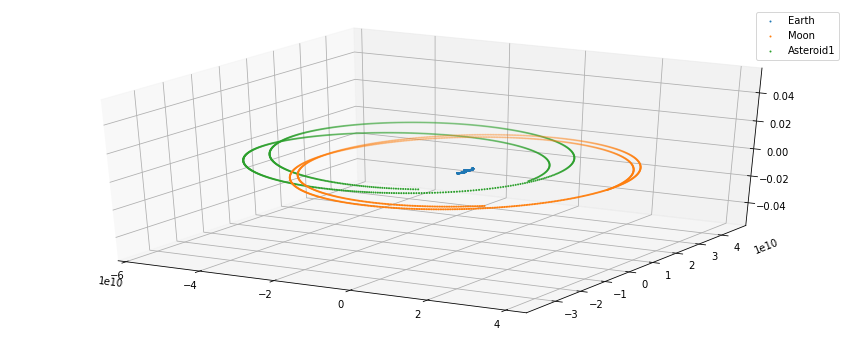

In [189]:
plot = plt.figure(figsize=[15, 6]).add_subplot(111, projection='3d')
    
for body_index in range(len(simulation.bodies)):
    plot.scatter([state[0 + 6 * body_index] for state in simulation.history],
               [state[1 + 6 * body_index] for state in simulation.history],
               [state[2 + 6 * body_index] for state in simulation.history], 
               s=1, label=simulation.bodies[body_index].name)

plot.legend()